## Deconvolution Simulation Experiments
## Part I - recapitulating data from reference panel 
#### Christa Caggiano 
#### July 18th 2018 


Simulations for cfDNA tissue of origin deconvolution. Given an observed matrix of methylation counts for each CpG from whole genome bisulfite sequencing, and a reference matrix of the cannonical proportion methylation for each CpG in each tissue, estimates how much of the cfDNA comes from each tissue in the reference. 

These simulations generate a variety of 'true' proportions and test how well our current algorithm is at recapitulating that proportion. 

**for experiment 1**, I will use tissues contained on the reference panel as 'observed methylation values' to examine the algorithm's baseline ability to estimate proportions in different conditions. This will be helpful in determining the optimal configuration for our real data to maximize our ability to truthfully predict cfDNA tissue of origin composition. 

#### Imports
Python packages and references to my deconvolution modules

In [2]:
#### python packages ####
import pandas as pd
import numpy as np 
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
from sklearn.metrics import mean_squared_error
%matplotlib inline

######### loading my python modules for deconvolution ########### 
#### https://github.com/christacaggiano/cfDNA-deconvolution #####

# this code needed to load my modules in a jupyter notebook 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from simulation.simulation_utils import *  # various utils for making simulated data 
from simulation.simulate import generate_simulated_optimization  # takes parameters and makes simulated matrices for optimization 
from optimization.quadratic_programming_optimization import perform_optimization as qp  # performs quadratic programming optimization
from optimization.naive_optimization import perform_optimization as naive  # 'naive' optimization that divides by sum 

#### Load Data
This data is from the [Roadmap Consortium's processed whole genome bisulfite sequencing data](https://egg2.wustl.edu/roadmap/web_portal/processed_data.html#MethylData). They analyzed ~40 tissues and cell lines to find differentially methylated regions. 

Data processing by Roadmap -- *As a general resource for epigenomic comparisons across all epigenomes, we defined DMRs using the Lister et al method (Lister et al. (2013)), combining all differentially methylated sites (DMSs) within 250bp of one another into a single DMR and excluded any DMR with less than 3 DMSs. For each DMR in each sample, we computed its average methylation level, weighted by the number of reads overlapping it (Schultz et al. (2012)). This resulted in a methylation level matrix with rows of DMRs and columns of samples.*

I have selected 10 tissues/cell lines to start. These tissues are **neurosphere cell line, liver, brain germinal matrix, brain hippocampus, heart atrium, heart ventricle, thymus, spleen cd34+ cells, and 4star (random cell line that comes from UCSF, should be very different than any other tissue).** I took these 10 tissues and made a separate csv file in order to make it easier to load. 

In [3]:
# Tissues included in this data set, in the order that they appear
# neurosphere	liver	brain_germinal	brain_hipp	atrium 	ventricle	thymus 	spleen	cd34	4star

roadmap_dmrs = pd.read_csv("../data/deconvolution_exp1_10_tissues.csv")  # load in the roadmap dmrs
roadmap_dmrs_drop_na = roadmap_dmrs.dropna()  # for now, just drop any missing data. Later experiments will test ways of dealing with Na's more intelligently 

### Experiment 1: 

__Goal__: Making mixtures of tissues that are __contained in the reference set__. I want to learn how accurate the deconvolution algorithm is at identifying a mixture with no noise and no outside tissues.  

**Outline** 
* Take sites that are the top 10,000 variable sites in the Roadmap project differentially methylated regions
* Choose one tissue- in this example, brain - that is contained in the reference set and set it to a range of proportions in an observed mixture
* Make a mix of _n_ tissues, where other tissues are random proportions but brain is kept fixed 
* No noise around CpG values in the observed data 

#### Optimization Simulation Function

Master function to create simulated matrices and perform the quadratic programming optimization. Calls functions loaded from code at https://github.com/christacaggiano/cfDNA-deconvolution, namely from simulate/ and optimize/ This code cannot be modified from this ipython notebook. 

In [7]:
def run_optimization(individuals, sites, tissues, read_depth, method, reference, fixed_proportion, column):
    """
    this function controls the simulation, by generating the simulated matrices given a set of parameters and 
    running the optimization using method of choice 
    
    :param individuals (int) number of individuals in the matrices (since optimization is only 1 person at a time, this is usually one. Will change later)
    :param sites (int) number of CpGs in reference and observed matrix- must be the same 
    :param tissues (int) number of tissues in the reference/tissue proportion matrices 
    :param read_depth (int) the read depth to generate simulated observed methylation values around 
    :param method (string) either "qp" or "naive"; optimization method 
    :param reference (np.array) numpy array of reference methylation values (dimensions: tissues x sites)
    :param fixed_proportion (float) value to fix one tissue at a given proportion in observed methylation counts
    :param column (int) column # of specific tissue to fix 
    
    :return 'true proportions' made by the simulation, the estimated proportions from the optimization 
    """
    
    # generates proprotions where one tissue is fixed and all others are random such that total proportions = 1
    proportions = np.asarray(generate_proportion_fixed(individuals, tissues, fixed_proportion, column))  
    
    # observed percent methylated is the simulated proportions times reference
    observed = round_to_one(np.matmul(proportions, reference))  
    # read counts (ie number of methylated or unmethylated reads) are drawn from a 
    # poisson process around the read depth
    depth = generate_depth(sites, individuals, read_depth)
    methylated = generate_counts(depth, observed, sites, individuals)
    unmethylated = depth - methylated
      
    # start with estimate of the proportions where all tissues are equal 
    proportions_est = np.zeros((individuals, tissues)) + 0.5  
    proportions_est = proportions_est/(np.sum(proportions_est))

    # run optimization 
    return proportions, method(proportions_est, reference, methylated, unmethylated)


#### Reference Data from Roadmap

Since the roadmap data contains hundreds of thousands of sites, we restrict to the top 10,000 most variable sites to start. These should select for sites that are most likely to be informative of tissue differences in our reference panel.  

In [6]:
roadmap_dmrs = roadmap_dmrs_drop_na.iloc[:, 3:] # drop chrom information because it's not important for computation 
roadmap_dmrs["var"] = roadmap_dmrs.var(axis=1, skipna=True)  # calculate row variance 
roadmap_dmrs_top10000 = roadmap_dmrs.sort_values(by="var", ascending=False).iloc[:10000,:-1]  # take the top 10,000 most variable sites 

In [7]:
reference = roadmap_dmrs_top10000.as_matrix().T  # make reference a numpy array for computation

#### Experiment Parameters

Each sub-experiment has differing parameters for generating simulating data outlined in the 'experiment parameters' section. 

In [40]:
read_depths = [0.5, 5, 10, 30, 100, 1000]  # depths to sample aroudn 
tissue_percents = [10, 1, 0.1, 0.01]  # percent of one fixed tissue 
individuals = 1  # number of individuals to optimize around 
sites = reference.shape[1]  # number of CpG sites 
tissues = reference.shape[0]  # number of tissues in reference 
tissue_of_interest = 2  # tissue of interest to fix, in this case it is brain_germinal matrix
method = qp # optimization method, in this case, quadratic programming 
noise = 0  # no noise for right now 
replicates = 50  # perform simulation 50 times 

#### Run Simulation

Run optimization using the experiment parameters and my optimization function defined above. 

In [41]:
# run simulation for parameters above and take the average correlation between estimate and true proportions 
# for all replicates performed 

correlation = []

for percent in tissue_percents:
    read_depth_error = []
    
    for depth in read_depths: 
        error = 0
        
        for i in range(replicates):
            truth, guess = run_optimization(individuals, sites, tissues, depth, method, reference, percent, tissue_of_interest)
            error += (np.corrcoef(truth, guess)[0][1])
            
        read_depth_error.append(error/replicates)
    
    correlation.append(read_depth_error)


#### Plot

Plot read depth against average correlation

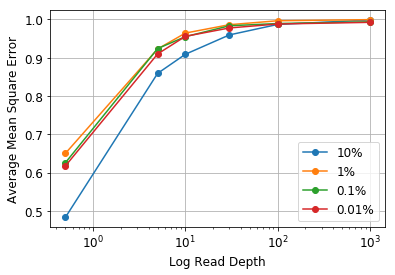

In [43]:
# plot the correlation vs read depth 

plt.rcParams.update({'font.size': 12})  # make the font size on the plot text bigger

for proportion_error, proportion in zip(correlation, tissue_percents):  # iterate over list of correlations and tissues 
    plt.plot(read_depths, proportion_error, '-o', label=str(proportion) + "%")
    plt.xscale("log")  # use log scale 
    
plt.xlabel("Log Read Depth")
plt.ylabel("Average Mean Square Error")
plt.grid()
plt.legend()

plt.show()

__*Plot 1*__: Read depth versus correlation between true simulated proportions and estimated proportions for a range of true fixed proportions. 

__Observation__ 10% seems to perform worse than expected, but maybe because with 10 tissues, 10% means approximately equal proportions of all tissues? I think this would in general, be very unlikely in real data. 

#### Run Simulation 

*plot 1* is an average of several points, but how does the error change across these replicates. AKA how reproducible are the estimates? 

In [17]:
# get an idea for the spread of error/correlation, not just the mean 

correlation = []

for percent in tissue_percents:
    each_percent_error = []
    
    for depth in read_depths: 
        depth_error = []
        
        for i in range(replicates):
            truth, guess = run_optimization(individuals, sites, tissues, depth, method, reference, percent, tissue_of_interest)
            depth_error.append(np.corrcoef(truth, guess)[0][1])  # all replicates 
        
        each_percent_error.append(depth_error)
    
    correlation.append(each_percent_error)


#### Plot

Visually inspect the distribution of estimates for a given read depth using a box plot

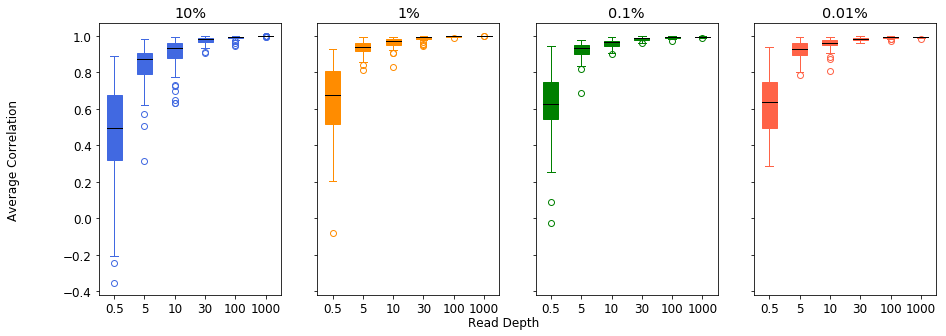

In [18]:
# make box plot of the error over 10 replicates 

plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, len(correlation), sharey=True, figsize=(15, 5)) # makes subplots that share a y axis
axes.ravel()

colors = ["royalblue", "darkorange", "green", "tomato"]  # set colors (default is white)
for i, c in zip(range(len(correlation)), colors): 
    
    axes[i].boxplot(correlation[i], patch_artist=True, # patch artist necessary to set color
                    
            # set the color individually for each aspect of the plot 
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color="black"))
    
    axes[i].set_title(str(tissue_percents[i]) + "%")
    axes[i].set_xticklabels(read_depths)

    
# gives commmon axis labels 
fig.text(0.5, 0.04, 'Read Depth', ha='center')
fig.text(0.04, 0.5, 'Average Correlation', va='center', rotation='vertical')

plt.show()


__*Plot 2*__: Spread of the correlation for ten replicates across four read depths and four levels of fixed tissue proportions 

__Observation__ Seems like what we would expect- the more reads, the more consistently we are able to estimate the proportions. As @Noah pointed out earlier, however, this doesn't really answer how well we are to predict the tissue that we are fixing/most interested in, only how well the algorithm performs overall. 

#### Run Simulation

Run the same simulation as above, this time keeping track of the difference between the true and estimated brain proportions over 10 replicates. 

In [44]:
# examine how well we can predict specifically brain, our tissue of interest 
# since this is now only one value, use the difference between the 'true' proportions (0.1, 0.01, 0.001, and 0.0001) and estimate 

difference = []

for percent in tissue_percents:
    percent_diff = []
    
    for depth in read_depths: 
        depth_diff = []
        
        for i in range(replicates):
            truth, guess = run_optimization(individuals, sites, tissues, depth, method, reference, percent, tissue_of_interest)
            depth_diff.append(truth[0][tissue_of_interest] - guess[tissue_of_interest])
        
        percent_diff.append(depth_diff)  # all 10 replicates 
    
    difference.append(percent_diff)


#### Plot 

Re-use boxplot code from above, but this time analyze the difference for true and estimated proportion of brain germinal matrix. 0 is now the 'ideal' value. 

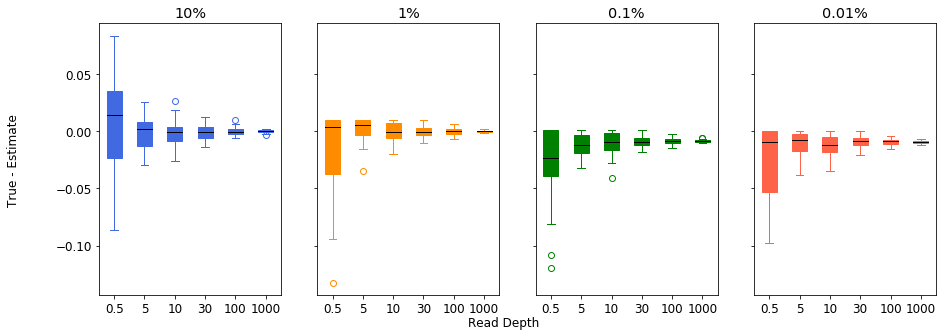

In [45]:
plt.rcParams.update({'font.size': 12})

# use difference matrix instead of correlation 
fig, axes = plt.subplots(1, len(difference), sharey=True, figsize=(15, 5)) # makes subplots that share a y axis
axes.ravel()

colors = ["royalblue", "darkorange", "green", "tomato"]  # set colors (default is white)
for i, c in zip(range(len(difference)), colors): 
    
    axes[i].boxplot(difference[i], patch_artist=True, # patch artist necessary to set color 
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color="black"))
    
    axes[i].set_title(str(tissue_percents[i]) + "%")
    axes[i].set_xticklabels(read_depths)

    
# gives commmon axis labels 
fig.text(0.5, 0.04, 'Read Depth', ha='center')
fig.text(0.04, 0.5, 'True - Estimate', va='center', rotation='vertical')

plt.show()

__*Plot 2a*__: Spread of the differences between true brain proportion and estimated for ten replicates across four read depths and four levels of fixed proportion. 

__Observation__ This plot is much more indicative. While above in *plot 2* it seemed that the algorithm was performing better with small tissue percentages of brain, our ability to estimate brain as it gets rarer, is worse. Interesting that it seems to be that with rarer proportions of brian, the tissue is consistently over estimated. 

### Experiment 1a: 
__Goal__: Within the tissue that we have, how well does the algorithm perform when we have differing numbers of tissues? 

In the future, this should be vastly expanded to ~100 tissues to make it a more realistic simulation. In this experiment, I will keep the read depth constant to be able to see more clearly how number of tissues affects accuracy. I chose [30x since this is commonly used in WGBS experiments](https://www.google.com/search?q=30x+read+coverage+wgbs&rlz=1C5CHFA_enUS760US760&oq=30x+read+coverage+wgbs&aqs=chrome..69i57.4502j0j4&sourceid=chrome&ie=UTF-8). I am also using the two most exterme tissue proportions to limit the computational constraints, since with only 10 replicates 2*10*10 becomes a lot of iterations to run on my local computer. Further work can fill in more tissue proportions. 

**Outline** 
* Use 2-10 number of tissues at 10% and 0.01% 
* Keep the number of sites (10,000) and replicates (10) the same as in experiment 1 
* Continue to use the 10,000 most variable sites. 
* Use one read depth of 30 

#### Parameters

Create several reference matrices by subsetting the one used in experiment1 above to a different range. Given the tissues in the matrix in this order: [neurosphere, liver, brain_germinal, brain_hipp, atrium, ventricle, thymus, 	spleen, cd34, 4star] the first reference w/ 2 tissues will contain [neurosphere, liver], the second reference with three tissues will contain [neurosphere, liver, brain_germinal], so on and so forth. 

Note- In the future, it may be good to make this process of forming the reference randomized. 

In [13]:
# change the reference so that it only encompasses a fixed range of tissues 

tissues = reference.shape[0]  # number of total tissues in reference 

reference_list = []  # keep references in a list of numpy arrays 

for i in range(2, tissues): 
    new_ref = reference[:i, :]  # subset the original reference matrix to a given column, keep all the rows (representing sites)
    reference_list.append(new_ref)
    

In [14]:
# amend parameters 

depth = 30  # 30x is a standard for WGBS experiments 
tissue_percents = [10, 0.01]  # use only the most extreme tissue percents to fix 
individuals = 1 
sites = reference.shape[1]
tissue_of_interest = 0  # allows for us to have less than 3 tissues 
method = qp 
noise = 0 
replicates = 1  # use 10 replicates -  will take very long locally, in which case, use 1for demonstration's sake

#### Run Simulation 

Run simulation in loop, for each tissue percent (10% and 0.01%), for each reference (2, 3, 4, ... 10 tissues large) and for each replicate. Calculate the correlation between the true proprotions and estimated. 

Note **invalid value encountered in less_equal** may occur in the early references with < 3 or 4 tissues because the tissues that were selected may not be variable in their sites, code returns NaN instead of a proportion estimate. In future, I should calculate the reference, then pick 10,000 variable sites... 

In [15]:
# get average correlation between truth and estimate for each tissue % and for the references with varying number of tissues 

correlation = []

for percent in tissue_percents:
    ref_error = []
    
    for ref in reference_list: 
        error = 0
        
        for i in range(replicates):
            tissues = ref.shape[0]
            truth, guess = run_optimization(individuals, sites, tissues, depth, method, ref, percent, tissue_of_interest)
            error += (np.corrcoef(truth, guess)[0][1])
        
        ref_error.append(error/replicates)  # average correlation 
    
    correlation.append(ref_error)
    

/usr/local/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:44: RuntimeWarning: invalid value encountered in greater_equal
  return (n >= 0) & (p >= 0) & (p <= 1)
/usr/local/lib/python3.6/site-packages/scipy/stats/_discrete_distns.py:44: RuntimeWarning: invalid value encountered in less_equal
  return (n >= 0) & (p >= 0) & (p <= 1)


#### Plot

For each number of tissues, what is the average correlation for 10% and 0.01%? In this plot, only using references with 5-10 number of tissues, to avoid problem above with some NaNs when sites are all 0 at a given location  

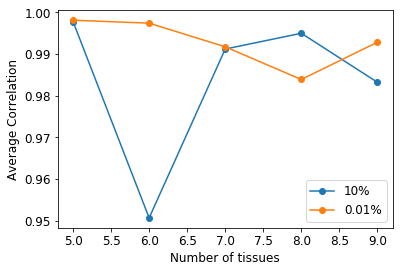

In [17]:
tissues = list(range(2, 10))

plt.rcParams.update({'font.size': 12})
for error, percent in zip(correlation, tissue_percents):
    plt.plot(tissues, error, '-o', label=str(percent) + "%")
    
plt.xlabel("Number of tissues")
plt.ylabel("Average Correlation")
plt.legend()

plt.show()

# error 

__*Plot 3*__: Number of tissues versus correlation between true simulated proportions and estimated proportions keeping one tissue fixed at 10% and 0.01%. Read depth of 30x.  

__Observation__ Correlation seems to get only worse when the number of tissues approaches the percent. I don't think this would be a problem for our data, as I think the number of tissues will be >> the contribution of one tissue? Seems sensitive to the number of replicates 

### Experiment 1b: 
__Goal__: Next, I want to ask/answer the question- how many sites are needed to get accurate estimates? Is 10,000 too little? Is there a saturation point where more sites is  no longer useful, i.e. is 100 sites as good as 10,000? 

**Outline** 
* Use top 100,000, 10,000, 1,000 and 100 sites 
* keep 4 tissue percentages of brain, and make overall correlation and difference between true/estimated brain 
* continue to use a fixed read depth of 30x

#### Parameters

Again, make a list of numpy references, as in experiment 1a, but this time use different number of variable sites

In [10]:
# roadmap_dmrs_top100000 = roadmap_dmrs.sort_values(by="var", ascending=False).iloc[:100000,:-1]  # take the top 100,000 most variable sites 
# note- 100,000 sites is unfeasable to run on my local drive, and possibly too much for optimization algorithm? 
# as such, will not use it in analyses below 

roadmap_top_10000 = reference  # use same top 10,000 sites as before
roadmap_top_1000 = reference[:, :1000]  # subset to top 1,000 sites
roadmap_top_100 = reference[:, :100]  # top 100 sites 

reference_list = [roadmap_top_10000, roadmap_top_1000, roadmap_top_100]

In [33]:
depth = 30  # fixed read depth 
tissue_percents = [10, 1, 0.1, 0.01]
individuals = 1 
tissue_of_interest = 2  # keep brain as the tissue of interest to fix 
method = qp
noise = 0 
replicates = 50

#### Run Simulation

Find the average correlation over 10 replicates for the range of fixed proportions of brain using references with a range of sites. 

Note- may also take a long time to run. 

In [34]:
# get average error correlation for three reference panels with different numbers of sites  

correlation = []

for percent in tissue_percents:
    ref_error = []
    
    for ref in reference_list:  # iterate over list of references with different number of sites
        error = 0
        
        for i in range(replicates):
            sites = ref.shape[1]  # make the number of sites in our observed the same as in the current reference 
            tissues = ref.shape[0]
            
            truth, guess = run_optimization(individuals, sites, tissues, depth, method, ref, percent, tissue_of_interest)
            error += (np.corrcoef(truth, guess)[0][1])
        
        ref_error.append(error/replicates)
    
    correlation.append(ref_error)
    

#### Plot 

Examine how the average overall correlation (across 10 replicates) varies by number of sites for each of the fixed tissue percentages.

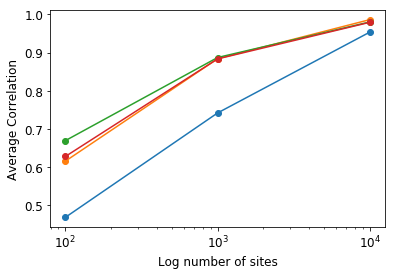

In [36]:
# @TODO add SD around points 

reference_size = [10000, 1000, 100]

plt.rcParams.update({'font.size': 12})
for error, percent in zip(correlation, tissue_percents):
    plt.plot(reference_size, error, '-o', label=str(percent) + "%")
    plt.xscale("log")

    
plt.xlabel("Log number of sites")
plt.ylabel("Average Correlation")

plt.show()

__*Plot 4*__: Log number of sites versus the correlation between true and estimated proportion for fixed tissue percentages. 

__Observation__ Makes sense. The more sites the better it seems! Especially if we expect a tissue to occur at a high percent? Seems roughly linear in log space. 

#### Run optimization 

Find the *spread* of differences between true brain prop and estimated over 10 replicates using references with a range of sites. 

Note- may also take a long time to run locally. 

In [46]:
# get the distribution of differences between true brain and the optimization estimate for the range of site numbers

difference = []

for percent in tissue_percents:
    ref_diff = []
    
    for ref in reference_list:  # iterate over list of references with different number of sites
        diff = []
        
        for i in range(replicates):
            sites = ref.shape[1]  # make the number of sites in our observed the same as in the current reference 
            tissues = ref.shape[0]
            
            truth, guess = run_optimization(individuals, sites, tissues, depth, method, ref, percent, tissue_of_interest)
            diff.append(truth[0][tissue_of_interest] - guess[tissue_of_interest])
        
        ref_diff.append(diff)
    
    difference.append(ref_diff)
    

#### Plot 

Make a barplot to examine how consistently the brain proportion is estimated using the given number of reference sites

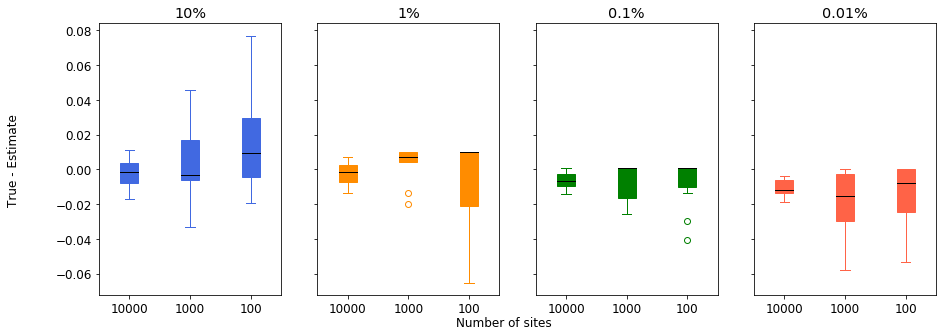

In [47]:
plt.rcParams.update({'font.size': 12})

# use difference matrix instead of correlation 
fig, axes = plt.subplots(1, len(tissue_percents), sharey=True, figsize=(15, 5)) # makes subplots that share a y axis
axes.ravel()

colors = ["royalblue", "darkorange", "green", "tomato"]  # set colors (default is white)
for i, c in zip(range(len(difference)), colors): 
    
    axes[i].boxplot(difference[i], patch_artist=True, # patch artist necessary to set color 
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color="black"))
    
    axes[i].set_title(str(tissue_percents[i]) + "%")  
    axes[i].set_xticklabels(reference_size) # instead of tissue percents, have it be number of sites 

    
# gives commmon axis labels 
fig.text(0.5, 0.04, 'Number of sites', ha='center')
fig.text(0.04, 0.5, 'True - Estimate', va='center', rotation='vertical')

plt.show()

__*Plot 4*__: For each number of sites, the distribution of difference between true brain proportion and the estimated proportion for 10 replicates. 

**Observation**: seems to consistently estimate higher than the true value 

### Experiment 1c: 

__Goal__: Making mixtures of tissues that are contained in the reference set __with noise__. Since it is very unlikely that our observed methylation WGBS data will be *exactly* like that contained in the reference panel, this makes for a more realistic simulation. 

Keep the parameters the same as experiment1, but rewrite optimization function such that it accomodates a noise parameter. This parameter will be a percentage 1-100 that will be used to create a random distribution of noise added to our observed methylation values. Since these values are meant to reflect real values, they will be constrained so that values less than 0 will be truncated to 0 and values greater than 1 will be truncated to 1. 

**Outline** 
* Again take sites that are the top 10,000 variable sites 
* Fix one tissue at a range of proportions, as above  
* Add noise in observations with values of 10, 1, 0.1, 0.01 percent

In [21]:
def run_optimization(individuals, sites, tissues, read_depth, method, reference, fixed_proportion, column, noise):
    """
    this function controls the simulation, by generating the simulated matrices given a set of parameters and 
    running the optimization using method of choice 
    
    :param individuals (int) number of individuals in the matrices (since optimization is only 1 person at a time, this is usually one. Will change later)
    :param sites (int) number of CpGs in reference and observed matrix- must be the same 
    :param tissues (int) number of tissues in the reference/tissue proportion matrices 
    :param read_depth (int) the read depth to generate simulated observed methylation values around 
    :param method (string) either "qp" or "naive"; optimization method 
    :param reference (np.array) numpy array of reference methylation values (dimensions: tissues x sites)
    :param fixed_proportion (float) value to fix one tissue at a given proportion in observed methylation counts
    :param column (int) column # of specific tissue to fix 
    
    :return 'true proportions' made by the simulation, the estimated proportions from the optimization 
    """
    
    # generates proprotions where one tissue is fixed and all others are random such that total proportions = 1
    proportions = np.asarray(generate_proportion_fixed(individuals, tissues, fixed_proportion, column))  
    
    
    # observed percent methylated is the simulated proportions times reference
    observed = np.matmul(proportions, reference)
    
    # add noise this time! 
    observed = np.matmul(proportions, reference)  # observed estimated is just reference times the proportions
    observed = round_to_one(observed + np.random.normal(0, noise/100, observed.shape))  # add small amounts of noise to observed
        
    # read counts (ie number of methylated or unmethylated reads) are drawn from a 
    # poisson process around the read depth
    depth = generate_depth(sites, individuals, read_depth) 
    methylated = generate_counts(depth, observed, sites, individuals)
    unmethylated = depth - methylated
    
    
    # start with estimate of the proportions where all tissues are equal 
    proportions_est = np.zeros((individuals, tissues)) + 0.5  
    proportions_est = proportions_est/(np.sum(proportions_est))

    
    # run optimization 
    return proportions, method(proportions_est, reference, methylated, unmethylated)


#### Parameters

optimization parameters stay the same as experiment one, but add a noise_range parameter that gives % noise 

In [22]:
# same as experiment 1 

reference = roadmap_top_10000  # just the standard top 10,000 sites used in experiment 1 
read_depths = [0.5, 5, 10, 30, 100, 1000]  # switch to a range of read depths
tissue_percents = [10, 1, 0.1, 0.01] 
individuals = 1 
sites = reference.shape[1]   
tissues = reference.shape[0]  
tissue_of_interest = 2  # brain tissue of interest 
method = qp 
noise_range = [10, 1, 0.1, 0.01] # logarithmic range of noise   
replicates = 50

#### Run Simulation 

for each level of noise, for each fixed percent of brain, and each read depth, find the average correlation coefficient for 10 replicates 

In [23]:
correlation = []
for noise in noise_range: 
    noise_error = []
    
    for percent in tissue_percents:
        each_percent_error = []

        for depth in read_depths: 
            error = 0 

            for i in range(replicates):
                truth, guess = run_optimization(individuals, sites, tissues, depth, method, reference, percent, tissue_of_interest, noise)
                error += (np.corrcoef(truth, guess)[0][1])

            each_percent_error.append(error/replicates)
        
        noise_error.append(each_percent_error)

    correlation.append(noise_error)


#### Plot 

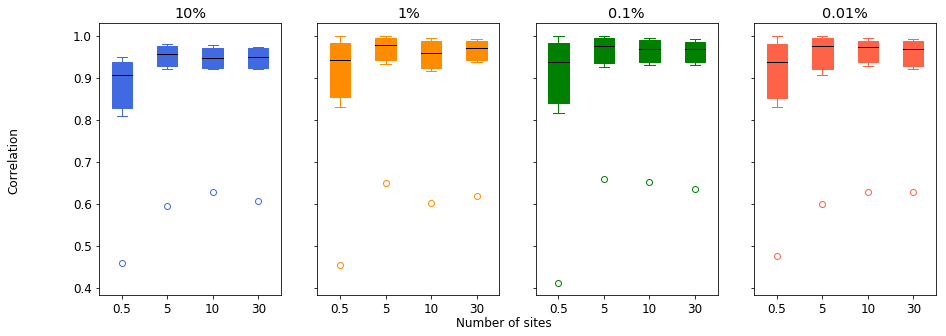

In [24]:
plt.rcParams.update({'font.size': 12})

# use difference matrix instead of correlation 
fig, axes = plt.subplots(1, len(tissue_percents), sharey=True, figsize=(15, 5)) # makes subplots that share a y axis
axes.ravel()

colors = ["royalblue", "darkorange", "green", "tomato"]  # set colors (default is white)
for i, c in zip(range(len(correlation)), colors): 
    
    axes[i].boxplot(correlation[i], patch_artist=True, # patch artist necessary to set color 
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color="black"))
    
    axes[i].set_title(str(tissue_percents[i]) + "%")  
    axes[i].set_xticklabels(read_depths) # instead of tissue percents, have it be number of sites 

    
# gives commmon axis labels 
fig.text(0.5, 0.04, 'Number of sites', ha='center')
fig.text(0.04, 0.5, 'Correlation', va='center', rotation='vertical')

plt.show()

__*Plot 5*__: The correlation between true proportions and estimated tissue proportions for four values of normally distributed noise in our observed methylated data, and four percents of fixed tissue contribution. 

__Observation__ Pretty substantial difference between 10% and 1%, probably because of the 0/1 truncation.  

#### Run Simulation 

Redo simulation to just keep track of brain truth/estimated difference when the entire observed matrix has noise. Fix depth at 30x to be consistent and limit computation. 

In [63]:
# examine how well we can predict specifically brain, our tissue of interest 
# since this is now only one value, use the difference between the 'true' proportions (0.1, 0.01, 0.001, and 0.0001) and estimate 

depth = 30 
difference = []

for percent in tissue_percents:
    percent_diff = []
    
    for depth in read_depths: 
        depth_diff = []
        
        for i in range(replicates):
            truth, guess = run_optimization(individuals, sites, tissues, depth, method, reference, percent, tissue_of_interest, noise)
            depth_diff.append(truth[0][tissue_of_interest] - guess[tissue_of_interest])
        
        percent_diff.append(depth_diff)  # all 10 replicates 
    
    difference.append(percent_diff)


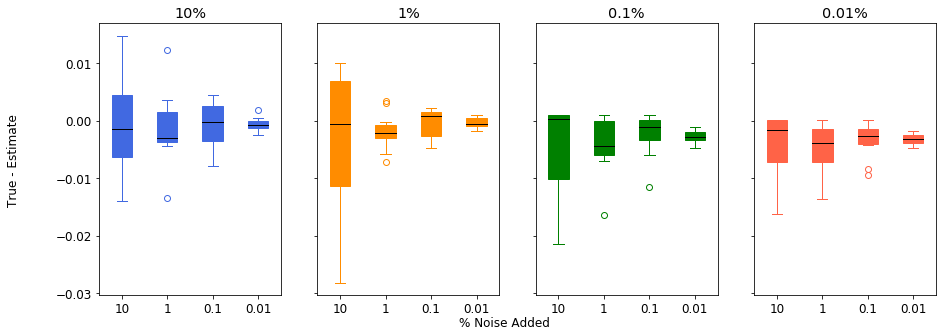

In [64]:
plt.rcParams.update({'font.size': 12})

# use difference matrix instead of correlation 
fig, axes = plt.subplots(1, len(tissue_percents), sharey=True, figsize=(15, 5)) # makes subplots that share a y axis
axes.ravel()

colors = ["royalblue", "darkorange", "green", "tomato"]  # set colors (default is white)
for i, c in zip(range(len(difference)), colors): 
    
    axes[i].boxplot(difference[i], patch_artist=True, # patch artist necessary to set color 
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color="black"))
    
    axes[i].set_title(str(tissue_percents[i]) + "%")  
    axes[i].set_xticklabels(noise_range) # instead of tissue percents, have it be number of sites 

    
# gives commmon axis labels 
fig.text(0.5, 0.04, '% Noise Added', ha='center')
fig.text(0.04, 0.5, 'True - Estimate', va='center', rotation='vertical')

plt.show()

__*Plot 5a*__: the difference between true brain proportion and estimated when noise is added for 30x read depth. 

### Experiment 1d: 

__Goal__: does the correlation continue when we pick random sites instead of the most variable? Is top most variable the best way to pick sites for these experiments? 

**Outline**: 
* keep all the parameters of experiment 1 the same, but use 10,000 sites randomly selected from the roadmap variable regions 

#### Parameters

Use the pandas random sample feature to pick 10,000 variable sites from the roadmap reference panel 

In [65]:
roadmap_dmrs = roadmap_dmrs_drop_na.iloc[:, 3:]  # drop na's 
roadmap_dmrs_sample = roadmap_dmrs.sample(n=10000)  # pick random sites
reference = roadmap_dmrs_sample.as_matrix().T  # make a numpy matrix 

In [66]:
read_depths = [10, 30, 100, 1000]  # depths to sample aroudn 
tissue_percents = [10, 1, 0.1, 0.01]  # percent of one fixed tissue 
individuals = 1  # number of individuals to optimize around 
sites = reference.shape[1]  # number of CpG sites 
tissues = reference.shape[0]  # number of tissues in reference 
tissue_of_interest = 2  # tissue of interest to fix, in this case it is brain_germinal matrix
method = qp # optimization method, in this case, quadratic programming 
noise = 0  # no noise for right now 
replicates = 10  # perform simulation 50 times 

#### Run Optimization

repeat the optimization from experiment 1 with the randomly selected reference. 

In [54]:
# run simulation for parameters above and take the average correlation between estimate and true proportions 
# for all replicates performed 

correlation = []

for percent in tissue_percents:
    read_depth_error = []
    
    for depth in read_depths: 
        error = 0
        
        for i in range(replicates):
            truth, guess = run_optimization(individuals, sites, tissues, depth, method, reference, percent, tissue_of_interest, noise)
            error += (np.corrcoef(truth, guess)[0][1])
        
        read_depth_error.append(error/replicates)
    
    correlation.append(read_depth_error)


#### Plot

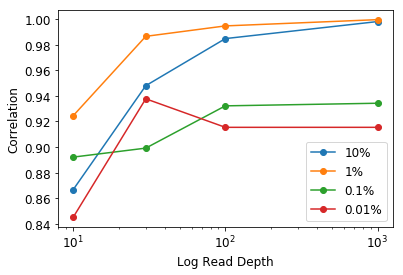

In [55]:
# plot the correlation vs read depth 

plt.rcParams.update({'font.size': 12})
for proportion_error, proportion in zip(correlation, tissue_percents):
    plt.plot(read_depths, proportion_error, '-o', label=str(proportion) + "%")
    plt.xscale("log")
    
plt.xlabel("Log Read Depth")
plt.ylabel("Correlation")
plt.legend()

plt.show()

__*Plot 6*__: Log read depth versus correlation between truth and estimate for four fixed tissue proportions using random CpGs for the reference set. 

__Observation__ This seems to decrease the effectiveness substantially from the top variable sites. Interesting because the sites are still from "differentially methylated regions" determined by ROADMAP, so good to know that even with sites that seem differentially methylated, we need to be more clever about picking them. 